<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Donut/CORD/Fine_tune_Donut_on_a_custom_dataset_(CORD)_with_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, let's install the relevant libraries:
* 🤗 Transformers, for the model
* 🤗 Datasets, for loading + processing the data
* PyTorch Lightning, for training the model 
* Weights and Biases, for logging metrics during training
* Sentencepiece, used for tokenization.

We'll use PyTorch Lightning for training here, but note that this is optional, you can of course also just train in native PyTorch or use 🤗 Accelerate, or the 🤗 Trainer.

In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 441 kB 5.0 MB/s 
     |████████████████████████████████| 1.3 MB 62.1 MB/s 
     |████████████████████████████████| 7.6 MB 58.0 MB/s 
     |████████████████████████████████| 163 kB 74.2 MB/s 
     |████████████████████████████████| 115 kB 74.4 MB/s 
     |████████████████████████████████| 212 kB 71.9 MB/s 
     |████████████████████████████████| 127 kB 72.1 MB/s 
     |████████████████████████████████| 115 kB 71.2 MB/s 


In [5]:
!pip install -q pytorch-lightning wandb

## Load dataset

Next, let's load the dataset from the [hub](https://huggingface.co/datasets/naver-clova-ix/cord-v2). The dataset consists of (image, JSON) pairs. Note that it doesn't have to be JSON, it could also be JSON lines, plain text, etc. 

In [6]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-6daad2d1fa36191a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

In [ ]:
dataset['train']

Let's take a look at the first training example:

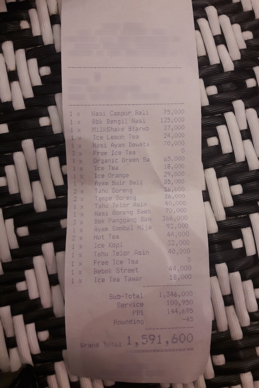

In [8]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [9]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "1 x", "price": "92,000"}, {"nm": "Hot Tea", "cnt": "2 x", "price

We can also parse the string as a Python dictionary using `ast.literal_eval`. Each training example has a single "gt_parse" key, which contains the ground truth parsing of the document:

In [10]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

## Load model and processor

Next, we load the model (which is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)), and the processor, which is the object that can be used to prepare inputs for the model.

We'll update some settings for fine-tuning, namely the image size and the max length of the decoder.

In [11]:
from transformers import VisionEncoderDecoderConfig

max_length = 768
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

Downloading:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

Next, we instantiate the model with our custom config, ass well as the processor.

In [12]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)

Downloading:   0%|          | 0.00/362 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values` and `labels`. Both are PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), and the `labels` are the `input_ids` of the target sequence (which is a flattened version of the JSON), with padding tokens replaced by -100 (to make sure these are ignored by the loss function). 

Note that we're also adding tokens to the vocabulary of the decoder (and corresponding tokenizer) for all keys of the dictionaries in our dataset, like "<s_menu>". This makes sure the model learns an embedding vector for them. Without doing this, some keys might get split up into multiple subword tokens, in which case the model just learns an embedding for the subword tokens, rather than a direct embedding for these keys.

In [13]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

Next, we instantiate the datasets:

In [14]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

train_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="validation", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Let's check which tokens are added:

In [15]:
len(added_tokens)

56

In [16]:
print(added_tokens)

['<s_menu>', '</s_menu>', '<s_nm>', '</s_nm>', '<s_cnt>', '</s_cnt>', '<s_price>', '</s_price>', '<s_sub_total>', '</s_sub_total>', '<s_subtotal_price>', '</s_subtotal_price>', '<s_service_price>', '</s_service_price>', '<s_tax_price>', '</s_tax_price>', '<s_etc>', '</s_etc>', '<s_total>', '</s_total>', '<s_total_price>', '</s_total_price>', '<s_sub>', '</s_sub>', '<s_cashprice>', '</s_cashprice>', '<s_changeprice>', '</s_changeprice>', '<s_menutype_cnt>', '</s_menutype_cnt>', '<s_menuqty_cnt>', '</s_menuqty_cnt>', '<s_discount_price>', '</s_discount_price>', '<s_unitprice>', '</s_unitprice>', '<s_total_etc>', '</s_total_etc>', '<s_creditcardprice>', '</s_creditcardprice>', '<s_num>', '</s_num>', '<s_discountprice>', '</s_discountprice>', '<s_emoneyprice>', '</s_emoneyprice>', '<s_void_menu>', '</s_void_menu>', '<s_othersvc_price>', '</s_othersvc_price>', '<s_vatyn>', '</s_vatyn>', '<s_itemsubtotal>', '</s_itemsubtotal>', '<s_cord-v2>', '<s_cord-v2>']


In [17]:
len(processor.tokenizer)

57580

In [18]:
processor.tokenizer.vocab_size

57522

You can verify that a token like `</s_unitprice>` was added:

In [19]:
processor.decode([57560])

'</s_unitprice>'

Let's check an example:

In [20]:
pixel_values, labels, target_sequence = train_dataset[0]

In [21]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [22]:
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
Nasi
Camp
ur
Bali
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
7
5,000
</s_price>
<sep/>
<s_nm>
B
b
k
Ben
gil
Nasi
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
12


In [23]:
print(target_sequence)

<s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm><s_cnt>1 x</s_cnt><s_price>40,000.</s_price><sep/><s_nm>Nasi Goren

IMPORTANT: for the `decoder_input_ids` to be created automatically, we need to set 2 variables:

In [24]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [25]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>


## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [26]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's verify a batch:

In [27]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [28]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
V
AN
BO
OLE
N
</s_nm>
<s_price>
9
,
000
</s_price>
<sep/>
<s_nm>
JO
NG
KO
NG
</s_nm>
<s_discountprice>
-
4
,
650
</s_discountprice>
<s_price>
15
,
500


In [29]:
print(len(train_dataset))
print(len(val_dataset))

800
100


In [30]:
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [31]:
print(target_sequences[0])

<s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total></s>


## Define LightningModule

Next, we define a LightningModule, which is an nn.Module with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [32]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = list()
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        return scores

    def validation_epoch_end(self, validation_step_outputs):
        # I set this to 1 manually
        # (previously set to len(self.config.dataset_name_or_paths))
        num_of_loaders = 1
        if num_of_loaders == 1:
            validation_step_outputs = [validation_step_outputs]
        assert len(validation_step_outputs) == num_of_loaders
        cnt = [0] * num_of_loaders
        total_metric = [0] * num_of_loaders
        val_metric = [0] * num_of_loaders
        for i, results in enumerate(validation_step_outputs):
            for scores in results:
                cnt[i] += len(scores)
                total_metric[i] += np.sum(scores)
            val_metric[i] = total_metric[i] / cnt[i]
            val_metric_name = f"val_metric_{i}th_dataset"
            self.log_dict({val_metric_name: val_metric[i]}, sync_dist=True)
        self.log_dict({"val_metric": np.sum(total_metric) / np.sum(cnt)}, sync_dist=True)

    def configure_optimizers(self):
        # TODO add scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [33]:
config = {"max_epochs":30,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

We'll use a custom callback to push our model to the hub during training (after each epoch + end of training). For that we'll log into our HuggingFace account.

In [34]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [36]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback

wandb_logger = WandbLogger(project="Donut", name="demo-run-cord")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training done")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        #logger=wandb_logger,
        #callbacks=[PushToHubCallback()],
)

trainer.fit(model_module)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
----------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
403.817   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_unitprice>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_unitprice>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.08069164265129683
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price></s_menu><s_total><s_total_price>16,000</s_total_price><s_cashprice>45,500</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.2219020172910663
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Susu Kolonel 1</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_sub_total><s_subtotal_price>23.000</s_subtotal_price></s_sub_total><s_total><s_total_price>50.000</s_total_price><s_cashprice>27.000</s_cashprice></s_total>
    Ans

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23,000</s_price></s_menu><s_total><s_total_price>23,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>27.000</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
    A

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluate

After training, we can evaluate the model on the test set.

As we pushed the model to the hub, we can very easily load it back again using the `from_pretrained` method. You can see in the [repo](https://huggingface.co/nielsr/donut-demo/tree/main) that we have the following files:

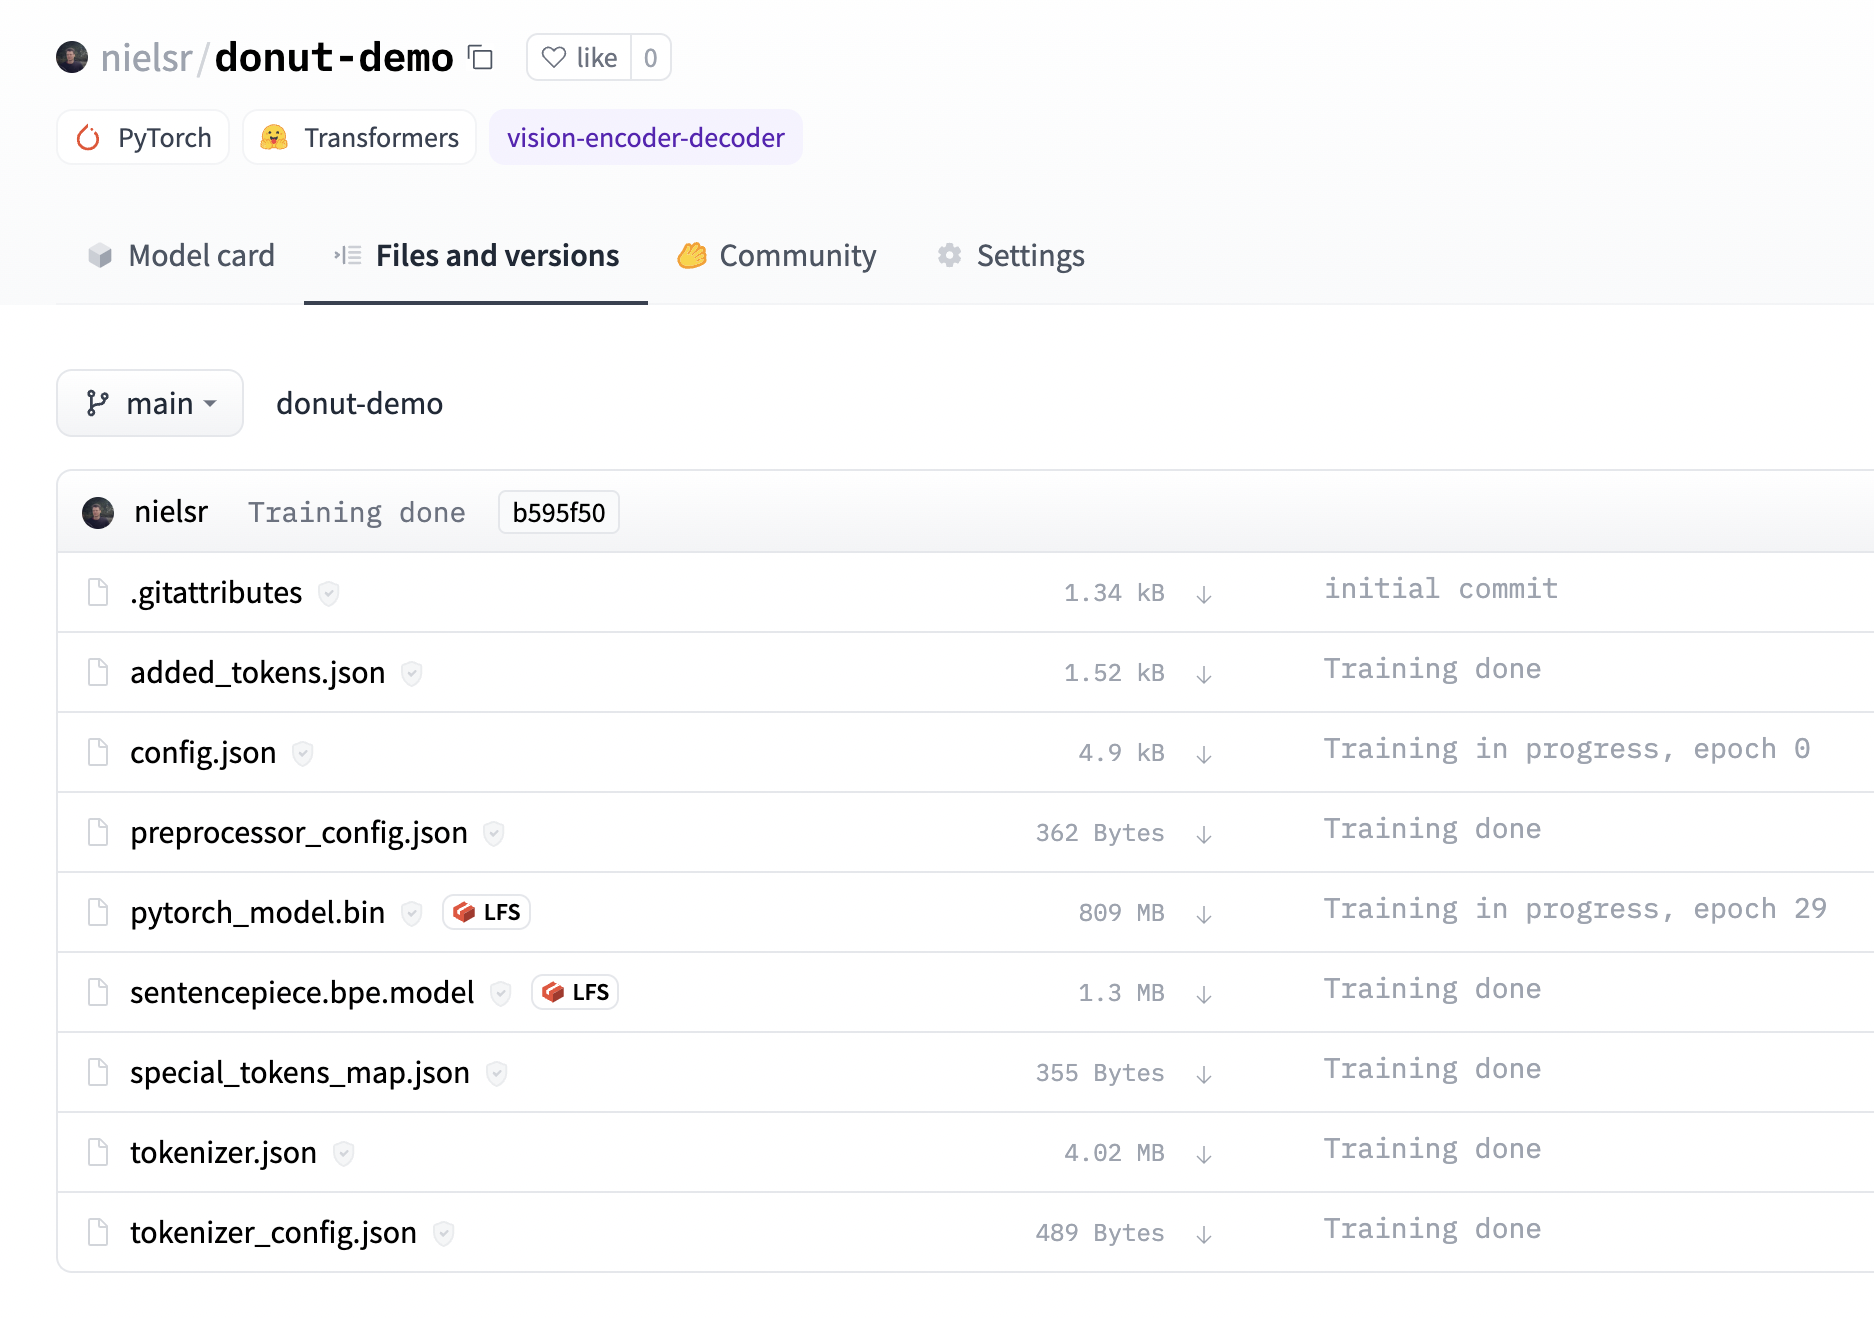

Note that you can also easily refer to a specific commit in the `from_pretrained` method using the [`revision`](https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/model#transformers.PreTrainedModel.from_pretrained.revision) argument, or use the private hub in case you'd like to keep your models private and only shared with certain colleagues for instance.

Here we're just loading from the main branch, which means the latest commit.

In [1]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("nielsr/donut-demo")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-demo")

Downloading:   0%|          | 0.00/362 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


As we don't have a test split here, let's evaluate on the validation split.

We'll use the `token2json` method of the processor to turn the generated sequences into JSON, and the `JSONParseEvaluator` object available in the Donut package.

In [2]:
!pip install -q donut-python

     |████████████████████████████████| 548 kB 6.4 MB/s 
     |████████████████████████████████| 109 kB 73.5 MB/s 
     |████████████████████████████████| 500 kB 67.7 MB/s 


In [8]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    print(seq)
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

  0%|          | 0/100 [00:00<?, ?it/s]

<s_cord-v2><s_menu><s_nm> REAL GANACHE</s_nm><s_cnt> 1</s_cnt><s_price> 16,500</s_price><sep/><s_nm> EGG TART</s_nm><s_cnt> 1</s_cnt><s_price> 13,000</s_price><sep/><s_nm> PIZZA TOAST</s_nm><s_cnt> 1</s_cnt><s_price> 16,000</s_price></s_menu><s_total><s_total_price> 45,500</s_total_price><s_cashprice> 50,000</s_cashprice><s_changeprice> 4,500</s_changeprice></s_total></s>
<s_cord-v2><s_menu><s_nm> Kopi Susu Kolonel</s_nm><s_cnt> 1</s_cnt><s_price> 23.000</s_price></s_menu><s_total><s_total_price> 23.000</s_total_price><s_cashprice> 50.000</s_cashprice><s_changeprice> 27.000</s_changeprice></s_total></s>
<s_cord-v2><s_menu><s_nm> S-Ovaltine</s_nm><s_unitprice> 20,000</s_unitprice><s_cnt> 1</s_cnt><s_price> 20,000</s_price><s_sub><s_nm> 50%</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price> 18,181</s_subtotal_price><s_tax_price> 1,818</s_tax_price></s_sub_total><s_total><s_total_price> 20,000</s_total_price><s_cashprice> 100,000</s_cashprice><s_changeprice> 80.000</s_changeprice></s_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-20a52eb5a6e9>", line 49, in <module>
    seq = processor.token2json(seq)
  File "/usr/local/lib/python3.7/dist-packages/transformers/models/donut/processing_donut.py", line 134, in token2json
    value = self.token2json(content, is_inner_value=True)
  File "/usr/local/lib/python3.7/dist-packages/transformers/models/donut/processing_donut.py", line 143, in token2json
    if leaf in self.tokenizer.get_added_vocab() and leaf[0] == "<" and leaf[-2:] == "/>":
  File "/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_fast.py", line 163, in get_added_vocab
    base_vocab = self._tokenizer.get_vocab(with_added_tokens=False)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/

KeyboardInterrupt: ignored

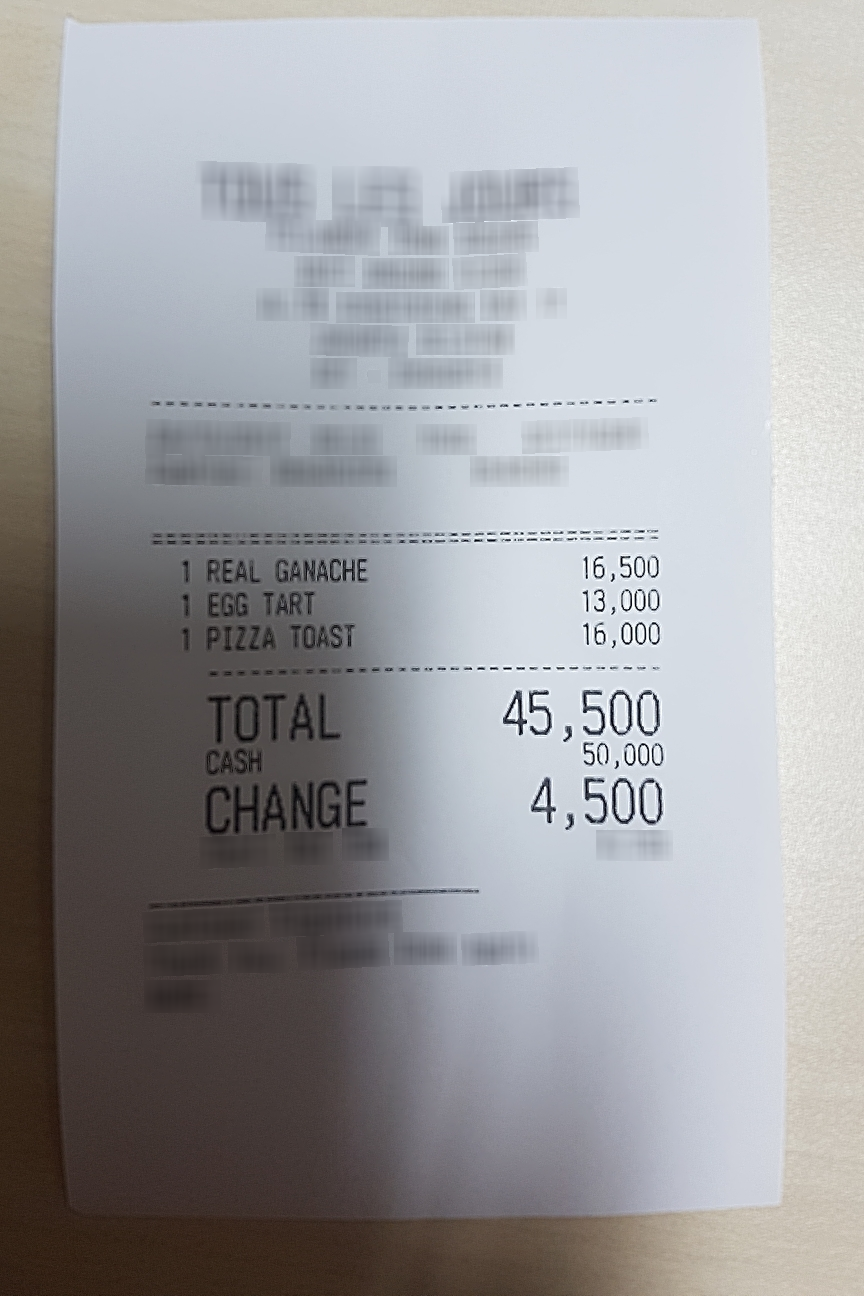

In [9]:
dataset["image"][0]

In [4]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.9215623005283509
